# TP1 : Principal Component Analysis and Support Vector Machines 

## Introduction

### Contexte & Objectifs

Durant ce premier TP, nous nous sommes familiarisé avec l’analyse en composantes principales (Principal Component Analysis, ou PCA) et les machines à vecteurs de support (Support Vector Machines, SVM).  

L’objectif principal est de classer des données botaniques associées à des espèces de fleurs, en utilisant un apprentissage supervisé.  
Pour ce faire, nous entrainerons un modèle avec des données se trouvant dans le fichier `flowerTrain.data`. Se trouve dans ce fichier un set de 48 échantillons pour chacune des trois espèces de fleurs : *interior*, *versicolor*, et *convoluta*. Quatre caractéristiques ont été mesurées pour chaque échantillon : la *longueur* et la *largeur* des **sépales**, ainsi que la *longueur* et la *largeur* des **pétales**.  
En se basant sur la combinaison de ces quatre caractéristiques, nous allons développer un modèle qui pourra déterminer si un nouvel échantillon est une fleur de type interior ou non (c’est-à-dire, appartenant à l’une des deux autres espèces).

Dans ce TP, nous suivrons les étapes suivantes :
1. Comme office d'entrainement, nous allons appliquer le PCA sur des ensembles de données en 2 dimensions (avec 4 points) afin de les réduire à 1 dimension.
2. Étendre le PCA au jeu de données complet (4 dimensions) pour le réduire à deux dimensions.
3. Concevoir une machine à vecteurs de support (SVM) sur les données de dimensions réduites pour classifier les échantillons comme étant « interior » ou « non interior ».
4. Tester le classificateur sur de nouveaux échantillons (Sect. 4).

Enfin, ce rapport se conclura sur la présentation de nos résultats.

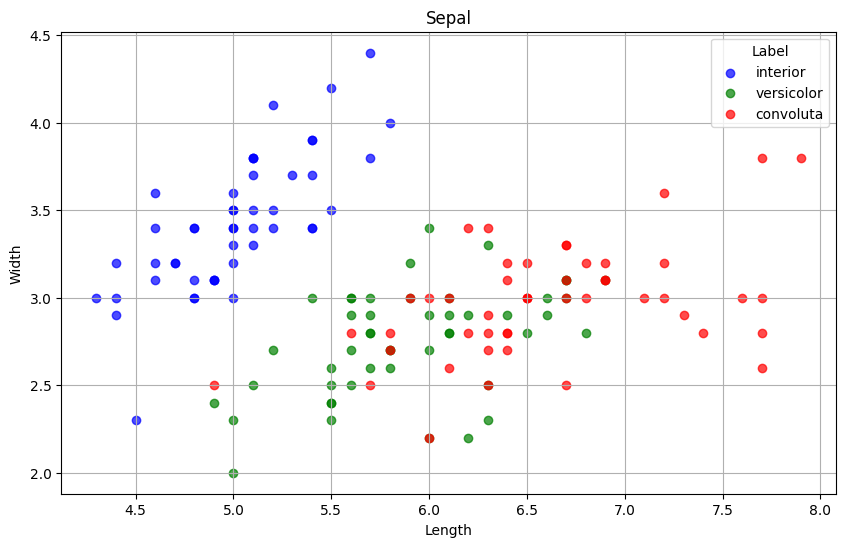

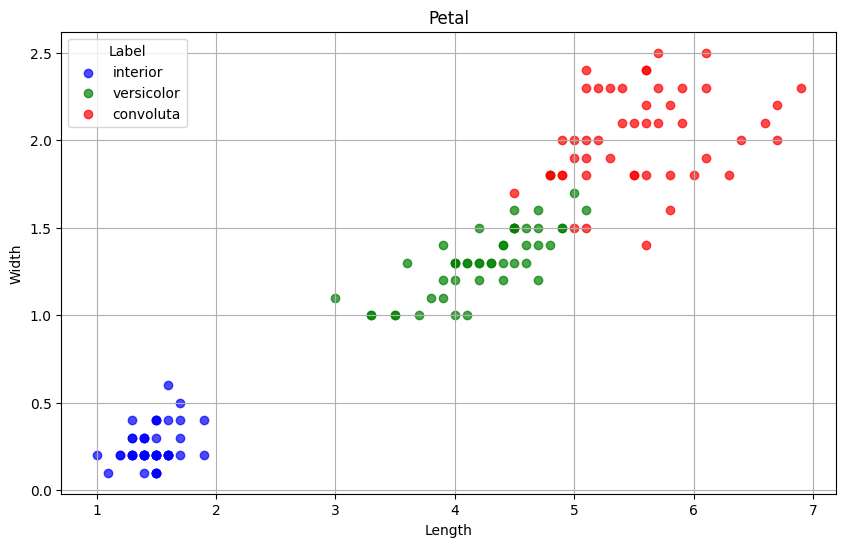

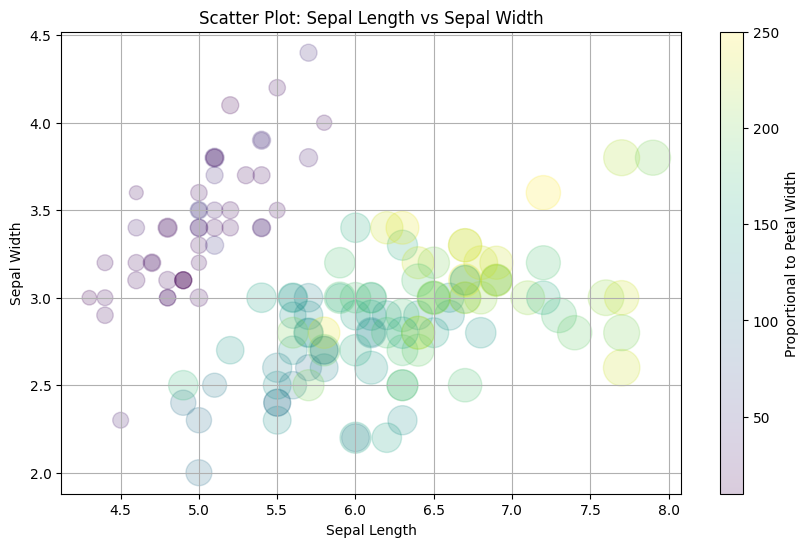

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.svm import SVC


# Charger le fichier dans un DataFrame
df = pd.read_csv('flowerTrain.data', header=None)

df.columns = ['length_sepals', 'width_sepals', 'length_petals', 'width_petals', 'species']

label_colors = {
    'interior': 'blue',
    'versicolor': 'green',
    'convoluta' : 'red',
}

df['Color'] = df['species'].map(label_colors)


plt.figure(figsize=(10, 6))
for label in df['species'].unique():
    subset = df[df['species'] == label]
    plt.scatter(subset['length_sepals'], subset['width_sepals'], color=subset['Color'].iloc[0], label=label, alpha=0.7)

plt.title("Sepal")
plt.xlabel("Length")
plt.ylabel("Width")
plt.legend(title="Label")
plt.grid(True)

# Plot 2 : Colonne 3 vs Colonne 4
plt.figure(figsize=(10, 6))
for label in df['species'].unique():
    subset = df[df['species'] == label]
    plt.scatter(subset['length_petals'], subset['width_petals'], color=subset['Color'].iloc[0], label=label, alpha=0.7)


plt.title("Petal")
plt.xlabel("Length")
plt.ylabel("Width")
plt.legend(title="Label")
plt.grid(True)



# ----------------------------------------------------------------------
# Tout afficher sur un seul plot
file_path = "flowerTrain.data"  # Remplacez par le chemin correct
data = pd.read_csv(
    file_path,
    names=['sepal length', 'sepal width', 'petal length', 'petal width', 'species']
)

# Extraire les colonnes pour la visualisation
x = data.iloc[:, 0:4]

# Création du graphique scatter
plt.figure(figsize=(10, 6))
plt.scatter(
    data.iloc[:, 0],  # sepal length
    data.iloc[:, 1],  # sepal width
    alpha=0.2,
    s=100 * data.iloc[:, 2],  # Taille proportionnelle à petal length
    c=100 * data.iloc[:, 3],  # Couleur proportionnelle à petal width
    cmap='viridis'  # Palette de couleurs
)

# Ajouter des titres et légendes
plt.title("Scatter Plot: Sepal Length vs Sepal Width")
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.colorbar(label='Proportional to Petal Width')
plt.grid(True)



# Afficher les graphiques
plt.show()


## I. L’analyse en composantes principales (PCA)

### Définitions & Utilité

Le PCA (Analyse en Composantes Principales) est une méthode statistique de réduction de dimension qui permet de réduire les dimensions d'un jeu de données tout en préservant au maximum l’information pertinente.  
Cette méthode est particulièrement utile lorsque les données présentent un grand nombre de variables, rendant l’analyse et l’apprentissage difficile.

Dans le cadre de notre TP, nous avons les longueurs et largeurs des pétales et des sépales, soit 4 dimensions (données). Nous allons les réduire à 2 dimensions.

---

### Étapes

**1. Standardisation des données**  
La standardisation se déroule en deux étapes : le calcul de la moyenne des données, puis le centrage des données.

- **Moyenne des données**  
Pour une matrice de données \( X \) (\( n \) échantillons et \( d \) caractéristiques), cette étape calcule la moyenne de chaque colonne \( \bar{X}_j \) :

\[
\bar{X}_j = \frac{1}{n} \sum_{i=1}^n X_{ij}
\]

où \( \bar{X}_j \) est la moyenne de la \( j \)-ième caractéristique.

- **Centrage des données**  
On centre les données en soustrayant la moyenne de chaque caractéristique :

\[
X'_{ij} = X_{ij} - \bar{X}_j
\]

Cela garantit que chaque caractéristique est centrée autour de 0.

**À quoi cela sert ?**  
- Assurer que les variables ayant de grandes valeurs absolues n'éclipsent pas les autres.
- Préparer les données pour une analyse basée sur la variance.

---

**2. Calcul de la matrice de covariance**  
La matrice de covariance \( C \) mesure les relations linéaires entre les différentes caractéristiques.

\[
C = \frac{1}{n-1} X'^T X'
\]

- \( X' \) : matrice centrée.
- \( C \) : matrice symétrique de dimension \( d \times d \), où chaque élément \( C_{ij} \) représente la covariance entre les caractéristiques \( i \) et \( j \).

**À quoi cela sert ?**  
- Identifier les relations linéaires entre les caractéristiques.
- Fournir une base pour détecter les directions principales dans les données.

---

**3. Calcul des valeurs et vecteurs propres**  
On effectue une décomposition propre de la matrice de covariance \( C \) :

\[
C v_i = \lambda_i v_i
\]

- \( v_i \) : vecteur propre correspondant à la \( i \)-ième composante principale.
- \( \lambda_i \) : valeur propre indiquant la quantité de variance expliquée par \( v_i \).

**À quoi cela sert ?**  
- Les **valeurs propres** déterminent quelles caractéristiques dominent dans la structure des données.
- Les **vecteurs propres** identifient les directions principales maximisant la variance des données.

---

**4. Sélection des \( p \) premières composantes principales**  
On sélectionne les \( p \) vecteurs propres associés aux \( p \) plus grandes valeurs propres.

**À quoi cela sert ?**  
- Réduire la dimensionnalité à \( p \) dimensions.
- Choisir un sous-espace plus simple tout en conservant la structure des données.

---

**5. Projection des données**  
Les données centrées \( X' \) sont projetées sur les \( p \) composantes principales :

\[
Z = X' \cdot W
\]

- \( W \) : matrice contenant les \( p \) premiers vecteurs propres (\( d \times p \)).
- \( Z \) : données projetées (\( n \times p \)).

**À quoi cela sert ?**  
- Générer une représentation compacte et interprétable des données.
- Faciliter la visualisation et l'analyse dans un espace réduit.

---

### Résultat global du PCA

Après avoir appliqué toutes ces étapes, nous obtenons :
1. Une matrice projetée \( Z \), représentant les données dans un espace de dimension réduite.
2. Les vecteurs propres, qui permettent d’interpréter les nouvelles dimensions.
3. Les valeurs propres, qui indiquent l'importance relative de chaque composante principale.

### Implémentation


In [2]:
def PCA(X, reducedDim):
    """
    Effectue une PCA sur la matrice X et projette les données
    dans un espace de dimension réduite.

    Paramètres:
        X (numpy.ndarray): Matrice de données (échantillons x caractéristiques).
        reducedDim (int): Nombre de dimensions cibles pour la projection.

    Retourne:
        s (numpy.ndarray): Données projetées dans l'espace réduit.
        eigenvalues (numpy.ndarray): Valeurs propres triées.
        eigenvectors (numpy.ndarray): Vecteurs propres correspondants.
    """
    # Step 1: Calcul de la moyenne pour chaque colonne
    mean = np.mean(X, axis=0)

    # Step 2: Centrage des données
    shift_mean = X - mean

    # Step 3: Calcul de la matrice de covariance
    number_lines = X.shape[0]
    covariance_matrix = np.dot(shift_mean.T, shift_mean) / (number_lines - 1)

    # Step 4: Calcul des valeurs propres et vecteurs propres
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Trier les valeurs propres et vecteurs propres en ordre décroissant
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Sélectionner les p vecteurs propres les plus significatifs
    Up = eigenvectors[:, :reducedDim]

    # Step 5: Projeter les données sur les dimensions réduites
    s = np.dot(shift_mean, Up)

    return s, eigenvalues, eigenvectors, Up

### 2.1 PCA on the Examples (work kind of)

Projected data (s):
[[-2.  0.]
 [ 2.  0.]
 [ 0. -1.]
 [ 0.  1.]]
Eigenvalues:
[2.66666667 0.66666667]
Eigenvectors:
[[1. 0.]
 [0. 1.]]
Projected data (s):
[[ 1.99995600e+00  0.00000000e+00]
 [-1.99995600e+00  1.11022302e-16]
 [ 3.44180471e-17  9.99978000e-01]
 [ 1.87631443e-16 -9.99978000e-01]]
Eigenvalues:
[2.66654933 0.66663733]
Eigenvectors:
[[-0.86601905  0.500011  ]
 [-0.500011   -0.86601905]]


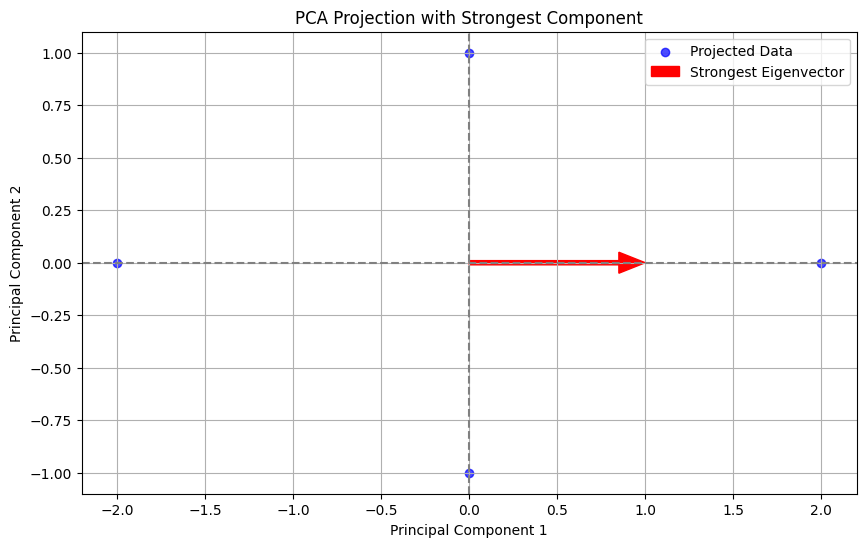

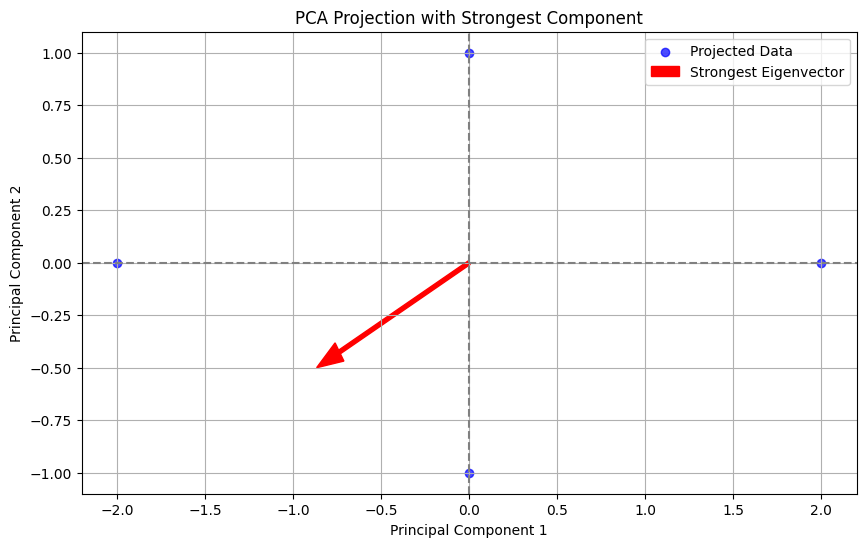

In [3]:
# Premier jeu de données
X = np.array([[1, 5, 3, 3], 
              [4, 4, 3, 5]])

X = X.T

# Appliquer la PCA avec p = 2
p = 2
s, eigenvalues, eigenvectors, Up = PCA(X, p)

print(f"Projected data (s):\n{s}")
print(f"Eigenvalues:\n{eigenvalues}")
print(f"Eigenvectors:\n{eigenvectors}")

# Plot des données projetées (2D)
plt.figure(figsize=(10, 6))

# Tracer les points projetés
plt.scatter(s[:, 0], s[:, 1], alpha=0.7, color="blue", label="Projected Data")

# Tracer uniquement la flèche pour la composante principale la plus forte
plt.arrow(
    0, 0,  # Origine de la flèche
    Up[0, 0], Up[1, 0],  # Composantes du vecteur propre principal
    color="red", width=0.02, head_width=0.1, length_includes_head=True, label="Strongest Eigenvector"
)

# Configurer le graphique
plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0, color="gray", linestyle="--")
plt.legend()
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection with Strongest Component")
plt.grid(True)

# Deuxième jeu de données
X = np.array([[1.268, 4.732, 3.5, 2.5], 
              [3, 5, 3.134, 4.866]])

X = X.T

# Appliquer la PCA avec p = 2
p = 2
s, eigenvalues, eigenvectors, Up = PCA(X, p)

print(f"Projected data (s):\n{s}")
print(f"Eigenvalues:\n{eigenvalues}")
print(f"Eigenvectors:\n{eigenvectors}")

# Plot des données projetées (2D)
plt.figure(figsize=(10, 6))

# Tracer les points projetés
plt.scatter(s[:, 0], s[:, 1], alpha=0.7, color="blue", label="Projected Data")

# Tracer uniquement la flèche pour la composante principale la plus forte
plt.arrow(
    0, 0,  # Origine de la flèche
    Up[0, 0], Up[1, 0],  # Composantes du vecteur propre principal
    color="red", width=0.02, head_width=0.1, length_includes_head=True, label="Strongest Eigenvector"
)

# Configurer le graphique
plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0, color="gray", linestyle="--")
plt.legend()
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection with Strongest Component")
plt.grid(True)


### 2.2 PCA on the Flower Data

Le PCA (Principal Component Analysis), ou Analyse en Composantes Principales, est une méthode statistique et d'apprentissage automatique utilisée pour réduire la dimensionnalité d'un ensemble de données tout en conservant le plus d'informations possible.



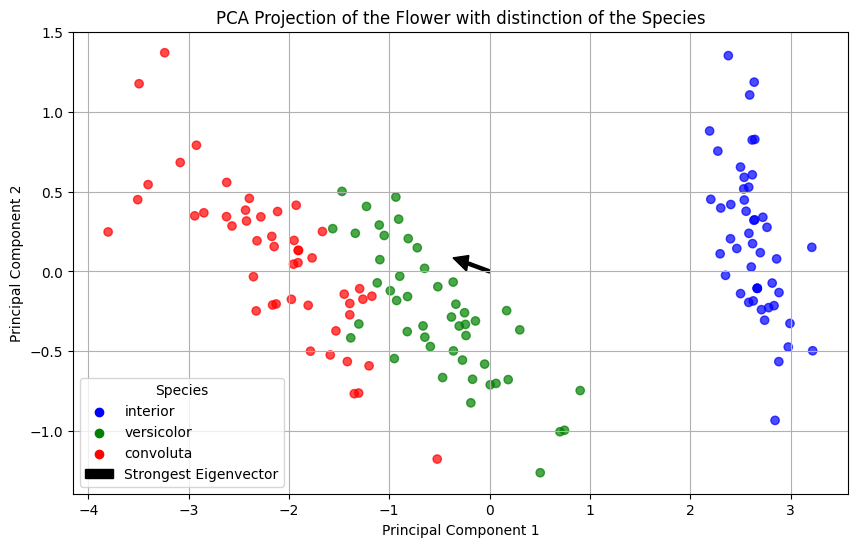

In [4]:
# Appliquer la PCA sur les données
data = df.iloc[:, 0:4].values
p = 2
s, eigenvalues, eigenvectors, Up = PCA(data, p)

# -----------------------------------------------
colors = df['Color'].values  # Extraire les couleurs pour chaque point

# Plot des données projetées avec les couleurs
plt.figure(figsize=(10, 6))
plt.scatter(s[:, 0], s[:, 1], c=colors, alpha=0.7)

# Ajouter une légende des espèces avec leurs couleurs
for species, color in label_colors.items():
    plt.scatter([], [], color=color, label=species)

# Afficher uniquement le vecteur propre correspondant à la composante principale la plus forte
origin = np.zeros(2)  # Origine pour les flèches
plt.arrow(
    origin[0], origin[1],  # Origine de la flèche
    eigenvectors[0, 0], eigenvectors[1, 0],  # Composantes du vecteur propre principal
    color="black", width=0.02, head_width=0.1, length_includes_head=True,
    label="Strongest Eigenvector"
)

# Configurer le graphique
plt.legend(title="Species")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of the Flower with distinction of the Species")
plt.grid(True)
plt.show()


## 2. Support Vector Machine

#### Hyperline:
L'hyperplane est une surface (une ligne en 2D, un plan en 3D, ou un hyperplan en dimensions supérieures) qui sépare les différentes classes dans l'espace des caractéristiques.  
En termes simples, l'hyperplane est la frontière centrale idéale qui divise les classes dans l'espace des données.

#### Frontières de Décision
Les frontières de décision sont des marges parallèles à l'hyperplane. Elles sont définies par wTx−b=1wTx−b=1 et wTx−b=−1wTx−b=−1 pour une SVM linéaire.  
Les frontières de décision représentent les "zones de non-retour" entre les classes. Les points en dehors des frontières sont bien classés, tandis que ceux sur les frontières ou proches sont critiques pour le modèle.

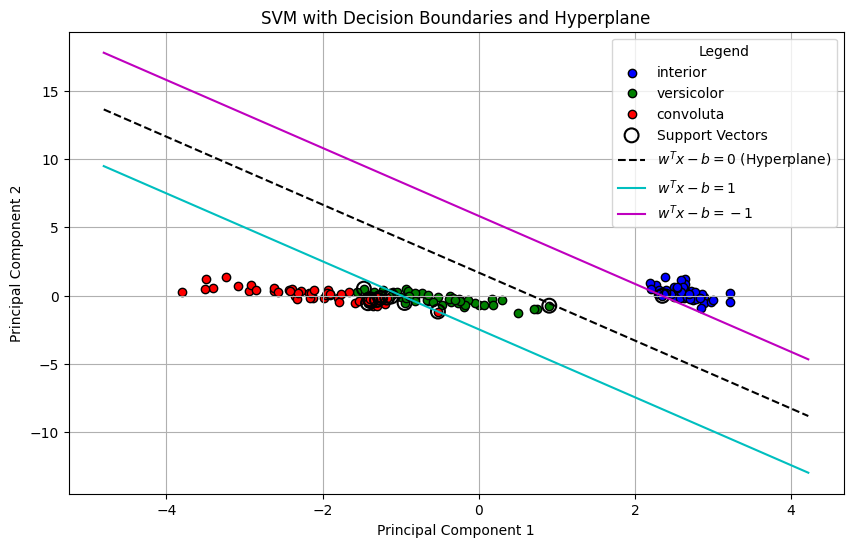

In [5]:
# Support Vector Machine
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 


X = s 
y = df['species']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

svm = SVC(kernel='linear', C=1E10)
svm.fit(X, y_encoded)



# Extraire w et b
w = svm.coef_[0]  # Coefficients de l'hyperplan
b = svm.intercept_[0]  # Biais

# Tracer les frontières de décision
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
xx = np.linspace(x_min, x_max, 500)
yy_hyperplane = -(w[0] * xx + b) / w[1]  # Equation de l'hyperplan
yy_decision_up = -(w[0] * xx + b - 1) / w[1]  # Frontière supérieure
yy_decision_down = -(w[0] * xx + b + 1) / w[1]  # Frontière inférieure

# Plot des données projetées
plt.figure(figsize=(10, 6))
for label, color in label_colors.items():
    mask = (df['species'] == label)
    plt.scatter(X[mask, 0], X[mask, 1], c=color, label=label, edgecolor='k')

# Tracer les vecteurs supports
plt.scatter(
    svm.support_vectors_[:, 0],
    svm.support_vectors_[:, 1],
    s=100, facecolors='none', edgecolors='k', linewidth=1.5, label='Support Vectors'
)

# Tracer l'hyperplan et les frontières de décision
plt.plot(xx, yy_hyperplane, 'k--', label=r"$w^Tx - b = 0$ (Hyperplane)")
plt.plot(xx, yy_decision_up, 'c-', label=r"$w^Tx - b = 1$")
plt.plot(xx, yy_decision_down, 'm-', label=r"$w^Tx - b = -1$")

# Configurer le graphique
plt.legend(title="Legend")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("SVM with Decision Boundaries and Hyperplane")
plt.grid(True)
plt.show()

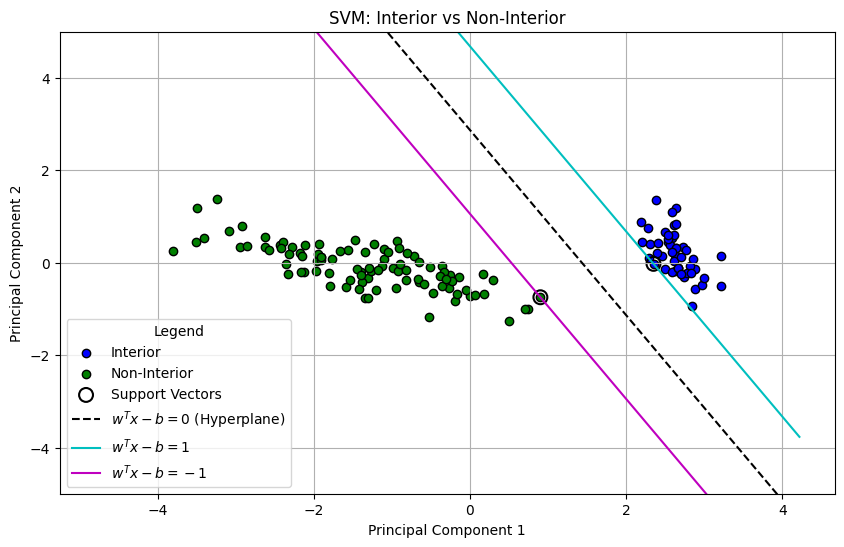

In [6]:
# Préparation des données
X = s  # Données projetées après PCA
y = df['species']

# Création d'un nouveau label pour séparer "interior" des autres
df['is_interior'] = (df['species'] == 'interior').astype(int)
y_binary = df['is_interior']

# Entraînement du SVM pour classifier "interior" vs "non-interior"
svm = SVC(kernel='linear', C=1E10)
svm.fit(X, y_binary)

# Extraire w et b pour tracer les frontières de décision
w = svm.coef_[0]  # Coefficients de l'hyperplan
b = svm.intercept_[0]  # Biais

# Génération des points pour tracer les frontières
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
xx = np.linspace(x_min, x_max, 500)
yy_hyperplane = -(w[0] * xx + b) / w[1]  # Hyperplan
yy_decision_up = -(w[0] * xx + b - 1) / w[1]  # Frontière supérieure
yy_decision_down = -(w[0] * xx + b + 1) / w[1]  # Frontière inférieure

# Visualisation
plt.figure(figsize=(10, 6))

# Plot des données projetées
plt.scatter(
    X[y_binary == 1, 0], X[y_binary == 1, 1],
    c='blue', label='Interior', edgecolor='k'
)
plt.scatter(
    X[y_binary == 0, 0], X[y_binary == 0, 1],
    c='green', label='Non-Interior', edgecolor='k'
)

# Tracer les vecteurs supports
plt.scatter(
    svm.support_vectors_[:, 0],
    svm.support_vectors_[:, 1],
    s=100, facecolors='none', edgecolors='k', linewidth=1.5, label='Support Vectors'
)

# Tracer l'hyperplan et les frontières de décision
plt.plot(xx, yy_hyperplane, 'k--', label=r"$w^Tx - b = 0$ (Hyperplane)")
plt.plot(xx, yy_decision_up, 'c-', label=r"$w^Tx - b = 1$")
plt.plot(xx, yy_decision_down, 'm-', label=r"$w^Tx - b = -1$")

# Configurer le graphique
plt.legend(title="Legend")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("SVM: Interior vs Non-Interior")
plt.ylim([-5, 5])
plt.grid(True)
plt.show()

## 4. Classify New Samples

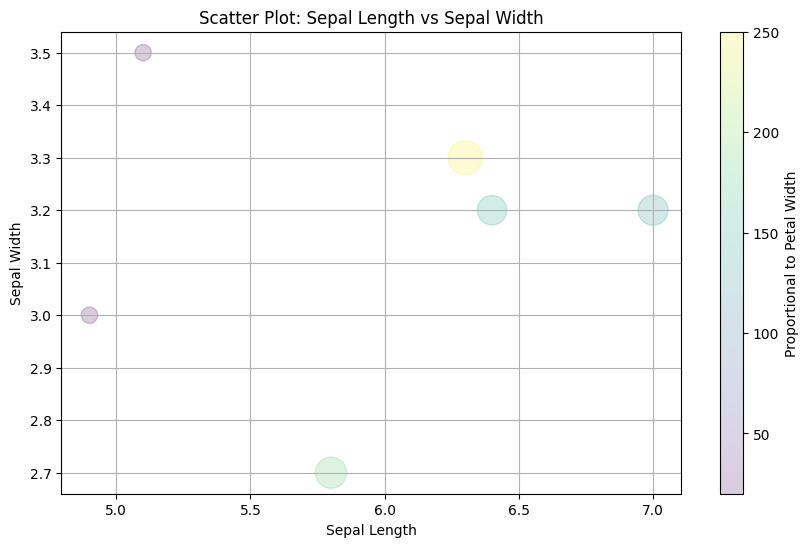

In [7]:
# Plot les datas
# Extraire les colonnes pour la visualisation
new_data = pd.read_csv(
    "new_flowerData.data",
    names=['sepal length', 'sepal width', 'petal length', 'petal width', 'species']
)

# Création du graphique scatter
plt.figure(figsize=(10, 6))
plt.scatter(
    new_data.iloc[:, 0],  # sepal length
    new_data.iloc[:, 1],  # sepal width
    alpha=0.2,
    s=100 * new_data.iloc[:, 2],  # Taille proportionnelle à petal length
    c=100 * new_data.iloc[:, 3],  # Couleur proportionnelle à petal width
    cmap='viridis'  # Palette de couleurs
)

# Ajouter des titres et légendes
plt.title("Scatter Plot: Sepal Length vs Sepal Width")
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.colorbar(label='Proportional to Petal Width')
plt.grid(True)



# Afficher les graphiques
plt.show()

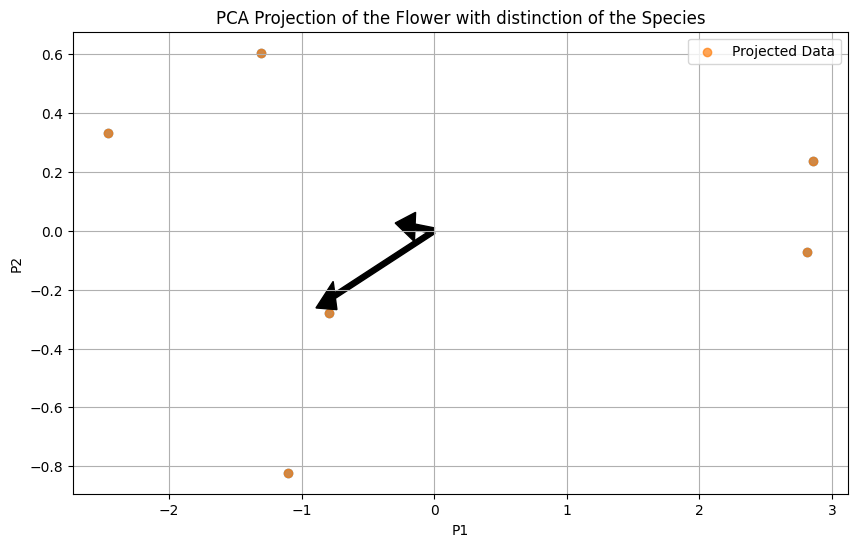

In [8]:
new_x = new_data.iloc[:, 0:4]

new_s, new_eigenvalues, new_eigenvectors, new_Up = PCA(new_x, 2)

# -----------------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(new_s[:, 0], new_s[:, 1], alpha=0.7)


plt.scatter(new_s[:, 0], new_s[:, 1], alpha=0.7, label="Projected Data")

# Afficher les vecteurs propres (eigenvectors) comme des flèches
origin = np.zeros(2)  # Origine des vecteurs
for i in range(p):
    plt.arrow(
        origin[0], origin[1],  # Point de départ de la flèche
        new_eigenvectors[0, i], new_eigenvectors[1, i],  # Composantes du vecteur propre (axe x, axe y)
        color="black", width=0.02, head_width=0.1, length_includes_head=True
    )


plt.legend()
plt.xlabel("P1")
plt.ylabel("P2")
plt.title("PCA Projection of the Flower with distinction of the Species")
plt.grid(True)

plt.show()

Prédictions pour les nouvelles données :
Sample 1: interior
Sample 2: non-interior
Sample 3: non-interior
Sample 4: non-interior
Sample 5: non-interior
Sample 6: interior


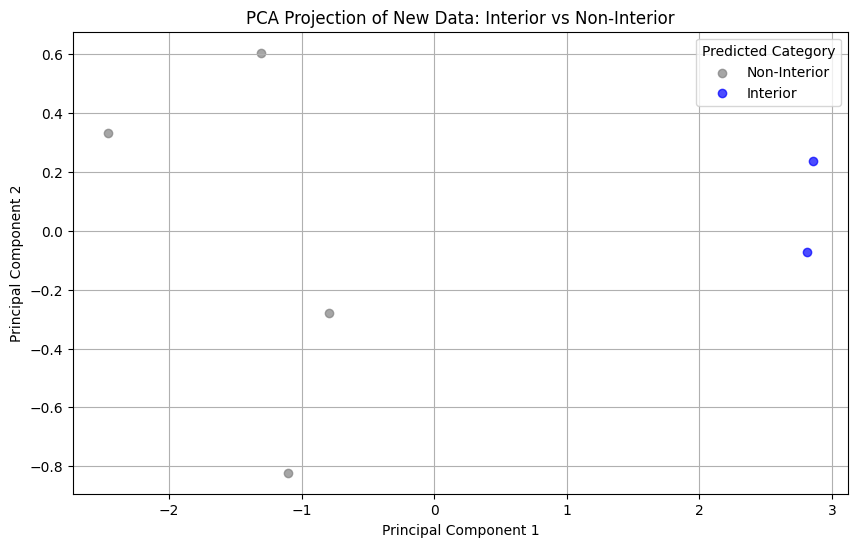

In [9]:
# Utiliser le modèle SVM pour prédire si une plante est "interior" ou non
predicted_binary_labels = svm.predict(new_s)  # Prédiction binaire (1 = interior, 0 = non-interior)

# Convertir les labels prédits en texte
predicted_species = np.where(predicted_binary_labels == 1, 'interior', 'non-interior')

# Afficher les résultats
print("Prédictions pour les nouvelles données :")
for i, species in enumerate(predicted_species):
    print(f"Sample {i+1}: {species}")

# Visualisation des données projetées avec leurs prédictions
plt.figure(figsize=(10, 6))

# Associer des couleurs pour "interior" et "non-interior"
binary_colors = {1: 'blue', 0: 'gray'}

# Tracer les données projetées
for binary_label in [0, 1]:
    mask = predicted_binary_labels == binary_label
    plt.scatter(
        new_s[mask, 0], new_s[mask, 1],
        color=binary_colors[binary_label],
        label='Interior' if binary_label == 1 else 'Non-Interior',
        alpha=0.7
    )

# Configurer le graphique
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of New Data: Interior vs Non-Interior")
plt.legend(title="Predicted Category")
plt.grid(True)
plt.show()